In [3]:
import optuna
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import ARIMA
from utilsforecast.evaluation import evaluate

import warnings
import logging

warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("optuna").setLevel(logging.WARNING)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
# Definir las métricas
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# Evaluación de métricas
def evaluate(cv_df, metrics):
    results = {}
    for metric in metrics:
        y_true = cv_df['y'].values
        y_pred = cv_df['ARIMA'].values
        results[metric.__name__] = metric(y_true, y_pred)
    return results

In [5]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1wk')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [6]:
horizon = 12

In [7]:
# Definir función para optimización por ticker
def optimize_for_ticker(ticker):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]

    print(f"Number of observations for {ticker}: {len(Y_df_ticker)}")

    # Eliminar filas con NaN en la columna 'y'
    if Y_df_ticker['y'].isnull().any():
        print(f"NaN values found in {ticker}. Cleaning data...")
        Y_df_ticker = Y_df_ticker.dropna(subset=['y']) 

    # Diccionario para almacenar las métricas
    metrics_dict = {}

    # Definir función objetivo para Optuna
    def objective(trial):
        order = (trial.suggest_int('p', 0, 2), 
                 trial.suggest_int('d', 0, 1), 
                 trial.suggest_int('q', 0, 2))
        seasonal_order = (trial.suggest_int('P', 0, 1), 
                          trial.suggest_int('D', 0, 1), 
                          trial.suggest_int('Q', 0, 1))
        season_length = trial.suggest_int('season_length', 1, min(52, len(Y_df_ticker)))

        # Instanciar el modelo ARIMA
        model = ARIMA(order=order, seasonal_order=seasonal_order, season_length=season_length)

        sf = StatsForecast(df=Y_df_ticker, models=[model], freq='W', n_jobs=-1)

        # Validación cruzada
        cv_df = sf.cross_validation(df=Y_df_ticker, h=horizon, step_size=horizon, n_windows=5).reset_index()

        # Evaluación de las predicciones
        evaluation_results = evaluate(cv_df.loc[:, cv_df.columns != 'cutoff'], metrics=[smape, mape, mse, mae, rmse])

        # Guardar las métricas para el análisis posterior
        metrics_dict[trial.number] = {
            'smape': evaluation_results['smape'],
            'mape': evaluation_results['mape'],
            'mse': evaluation_results['mse'],
            'mae': evaluation_results['mae'],
            'rmse': evaluation_results['rmse']
        }

        return evaluation_results['smape']

    # Optimización con Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=25)

    best_params = study.best_params
    best_trial = study.best_trial.number

    print(f"Best hyperparameters for {ticker}: {best_params}")
    print(f"Best SMAPE for {ticker}: {study.best_value}")
    print(f"Metrics for the best trial ({best_trial}): {metrics_dict[best_trial]}")

    return best_params, metrics_dict[best_trial]

In [8]:
# Crear modelo y predecir
def create_model_and_predict(ticker, best_params):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]

    # Crear modelo final con los mejores parámetros
    final_model = ARIMA(
        order=(best_params['p'], best_params['d'], best_params['q']),
        seasonal_order=(best_params['P'], best_params['D'], best_params['Q']),
        season_length=best_params['season_length']
    )

    sf_final = StatsForecast(df=Y_df_ticker, models=[final_model], freq='W', n_jobs=-1)

    prediction_length = len(Y_df_ticker) - horizon
    Y_df_real = Y_df_ticker[:prediction_length]

    sf_final.fit(Y_df_real)
    forecast = sf_final.forecast(h=horizon)

    print(f"Predictions for {ticker}:")
    print(forecast)

    return forecast

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_predictions(ticker, forecast):
    Y_df_ticker = Y_df[Y_df['unique_id'] == ticker]
    
    # Create the plot
    plt.figure(figsize=(12, 6))

    # Actual data (historical)
    real_series = Y_df_ticker[['ds', 'y']]  
    plt.plot(real_series['ds'], real_series['y'], label='Actual Data', linestyle='-', color='blue', linewidth=2)

    # Predictions
    forecast_series = forecast[['ds', 'ARIMA']]
    plt.plot(forecast_series['ds'], forecast_series['ARIMA'], label='Prediction', marker='x', color='orange', linestyle='--', linewidth=2)

    # Configure the plot
    plt.title(f'Predictions vs Actual Data for {ticker}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.xticks(rotation=45)
    
    # Set the x-axis limits to encompass both actual and forecast data
    all_dates = pd.concat([real_series['ds'], forecast_series['ds']])  # Define all_dates here
    plt.xlim([pd.Timestamp('2024-01-01'), all_dates.max() + pd.DateOffset(months=1)])  # Cutting the graph from January 1, 2024

    # Set the y-axis limit based on the ticker
    if ticker.lower() == 'nvda':
        plt.ylim(bottom=40)  # NVDA starts from 40
    elif ticker.lower() == 'btc-usd':
        plt.ylim(bottom=35000)  # BTC-USD starts from 30,000
    elif ticker.lower() == 'msft':
        plt.ylim(bottom=340)  # BTC-USD starts from 30,000
    elif ticker.lower() == 'amzn':
        plt.ylim(bottom=140)  # BTC-USD starts from 30,000
    elif ticker.lower() == 'meta':
        plt.ylim(bottom=300)  # BTC-USD starts from 30,000
    elif ticker.lower() == 'aapl':
        plt.ylim(bottom=140)  # BTC-USD starts from 30,000
    else:
        plt.ylim(bottom=120)  # All other tickers start from 150

    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Display the plot
    plt.tight_layout()
    plt.show()


In [10]:
# Optimización para cada ticker
best_params_dict = {}
for ticker in tickers:
    print(f"\nOptimizando para {ticker}...")
    best_params, best_metrics = optimize_for_ticker(ticker)
    if best_params is not None:
        best_params_dict[ticker] = best_params


Optimizando para AAPL...
Number of observations for AAPL: 1294
Best hyperparameters for AAPL: {'p': 1, 'd': 1, 'q': 2, 'P': 0, 'D': 1, 'Q': 1, 'season_length': 26}
Best SMAPE for AAPL: 5.408906564116478
Metrics for the best trial (0): {'smape': 5.408906564116478, 'mape': 5.318822339177132, 'mse': 201.03755, 'mae': 10.54831, 'rmse': 14.178771}

Optimizando para MSFT...
Number of observations for MSFT: 1294
Best hyperparameters for MSFT: {'p': 1, 'd': 0, 'q': 1, 'P': 1, 'D': 1, 'Q': 1, 'season_length': 34}
Best SMAPE for MSFT: 3.36122028529644
Metrics for the best trial (20): {'smape': 3.36122028529644, 'mape': 3.287941589951515, 'mse': 326.57843, 'mae': 13.233315, 'rmse': 18.071482}

Optimizando para GOOGL...
Number of observations for GOOGL: 1052
Best hyperparameters for GOOGL: {'p': 1, 'd': 0, 'q': 0, 'P': 0, 'D': 1, 'Q': 1, 'season_length': 4}
Best SMAPE for GOOGL: 5.471853166818619
Metrics for the best trial (21): {'smape': 5.471853166818619, 'mape': 5.458691343665123, 'mse': 110.7

[W 2024-10-11 12:11:28,922] Trial 1 failed with parameters: {'p': 1, 'd': 0, 'q': 0, 'P': 0, 'D': 0, 'Q': 1, 'season_length': 14} because of the following error: The value nan is not acceptable.
[W 2024-10-11 12:11:28,923] Trial 1 failed with value nan.


Best hyperparameters for AMZN: {'p': 1, 'd': 1, 'q': 2, 'P': 1, 'D': 1, 'Q': 1, 'season_length': 10}
Best SMAPE for AMZN: 3.7934105843305588
Metrics for the best trial (20): {'smape': 3.7934105843305588, 'mape': 3.7531305104494095, 'mse': 65.84919, 'mae': 6.1180644, 'rmse': 8.114752}

Optimizando para NVDA...
Number of observations for NVDA: 1294
Best hyperparameters for NVDA: {'p': 0, 'd': 1, 'q': 1, 'P': 1, 'D': 1, 'Q': 0, 'season_length': 38}
Best SMAPE for NVDA: 11.061915755271912
Metrics for the best trial (2): {'smape': 11.061915755271912, 'mape': 10.222956538200378, 'mse': 207.63408, 'mae': 9.848149, 'rmse': 14.409513}

Optimizando para META...
Number of observations for META: 648
Best hyperparameters for META: {'p': 1, 'd': 1, 'q': 0, 'P': 0, 'D': 1, 'Q': 1, 'season_length': 1}
Best SMAPE for META: 5.213557928800583
Metrics for the best trial (11): {'smape': 5.213557928800583, 'mape': 5.1648396998643875, 'mse': 1384.8785, 'mae': 24.585125, 'rmse': 37.213955}

Optimizando para I

In [11]:
# Crear y predecir
import time
forecasts_dict = {}

for ticker in tickers:
    if ticker in best_params_dict:
        print(f"\nCreando el modelo y realizando predicciones para {ticker}...")

        start_time = time.time()
        forecast = create_model_and_predict(ticker, best_params_dict[ticker])
        end_time = time.time()

        print(f"Tiempo de predicción para {ticker}: {end_time - start_time:.2f} segundos")
        forecasts_dict[ticker] = forecast


Creando el modelo y realizando predicciones para AAPL...
Predictions for AAPL:
                  ds       ARIMA
unique_id                       
AAPL      2024-07-21  218.072433
AAPL      2024-07-28  218.419769
AAPL      2024-08-04  217.874100
AAPL      2024-08-11  216.869705
AAPL      2024-08-18  217.230545
AAPL      2024-08-25  215.370636
AAPL      2024-09-01  214.749435
AAPL      2024-09-08  215.974564
AAPL      2024-09-15  215.411804
AAPL      2024-09-22  216.387619
AAPL      2024-09-29  217.002228
AAPL      2024-10-06  216.334564
Tiempo de predicción para AAPL: 14.82 segundos

Creando el modelo y realizando predicciones para MSFT...
Predictions for MSFT:
                  ds       ARIMA
unique_id                       
MSFT      2024-07-21  423.565277
MSFT      2024-07-28  420.699310
MSFT      2024-08-04  419.392548
MSFT      2024-08-11  421.549316
MSFT      2024-08-18  417.829041
MSFT      2024-08-25  422.599274
MSFT      2024-09-01  425.412842
MSFT      2024-09-08  424.589172
M


Graficando las predicciones para AAPL...


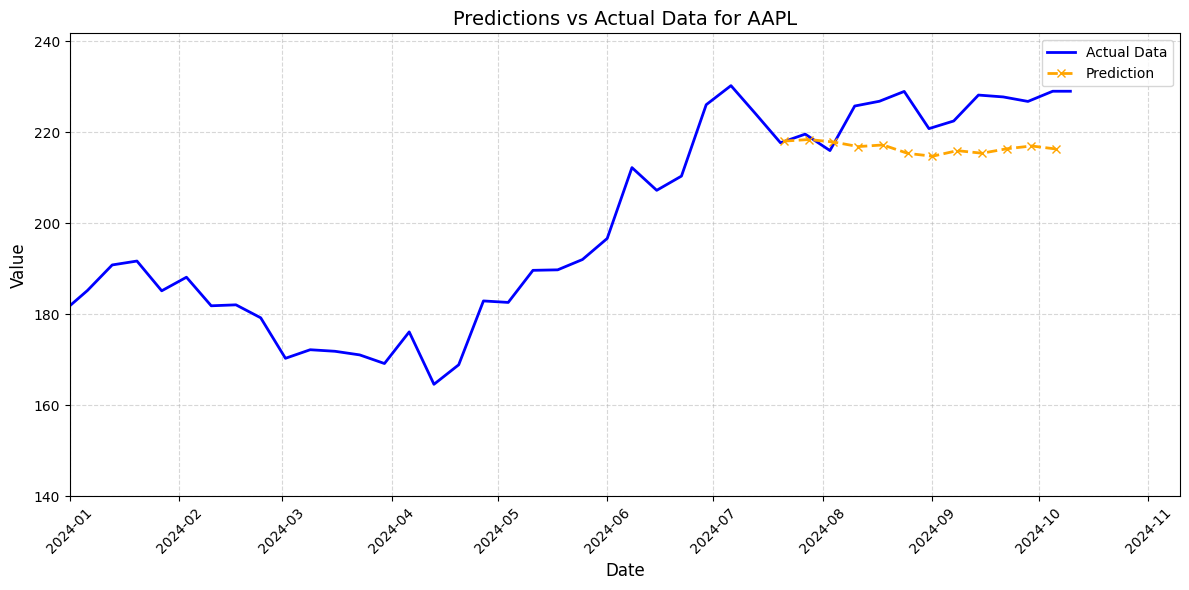


Graficando las predicciones para MSFT...


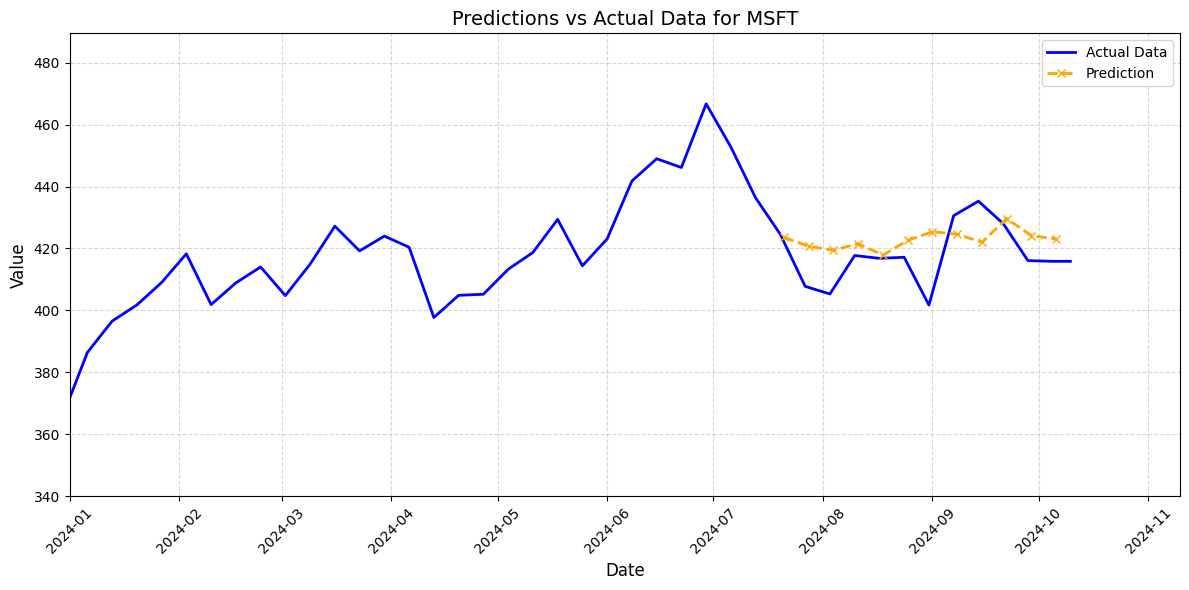


Graficando las predicciones para GOOGL...


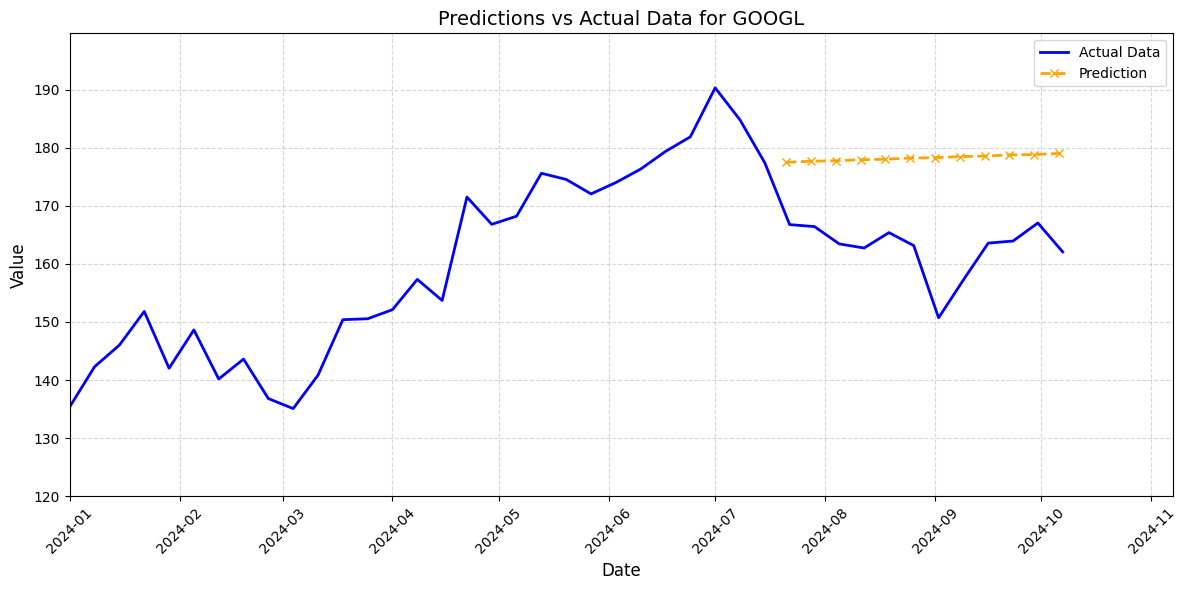


Graficando las predicciones para AMZN...


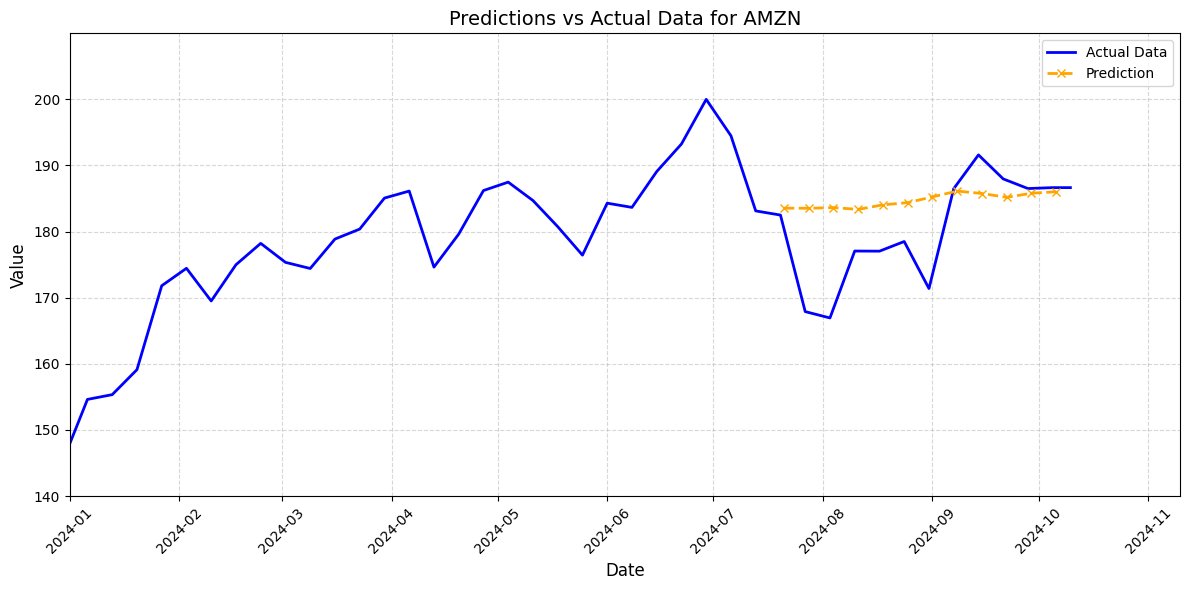


Graficando las predicciones para NVDA...


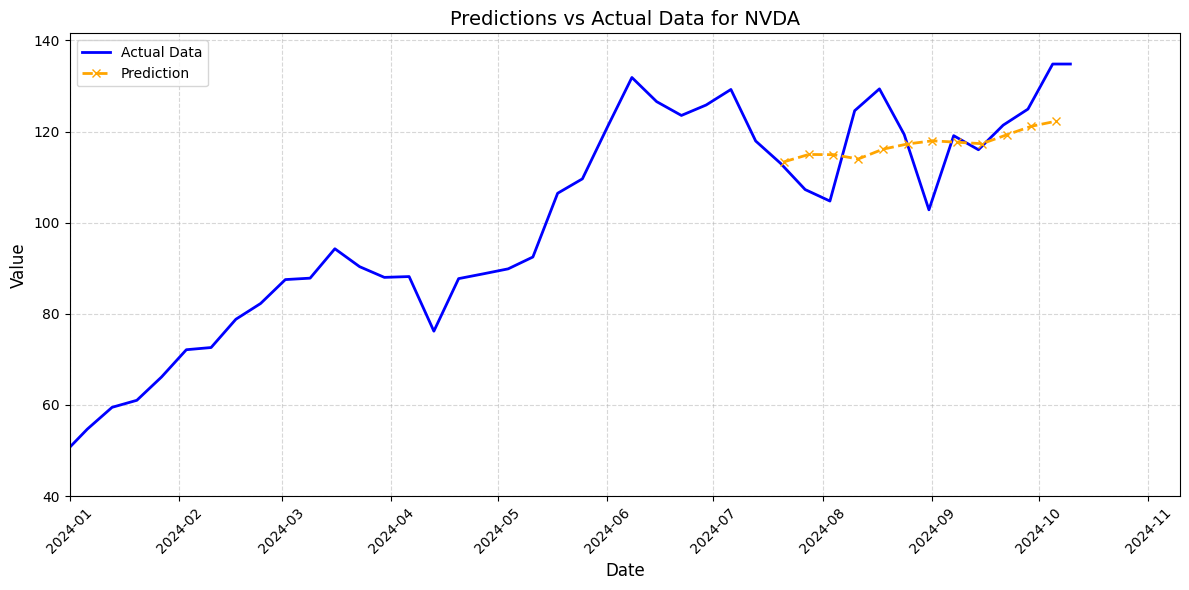


Graficando las predicciones para META...


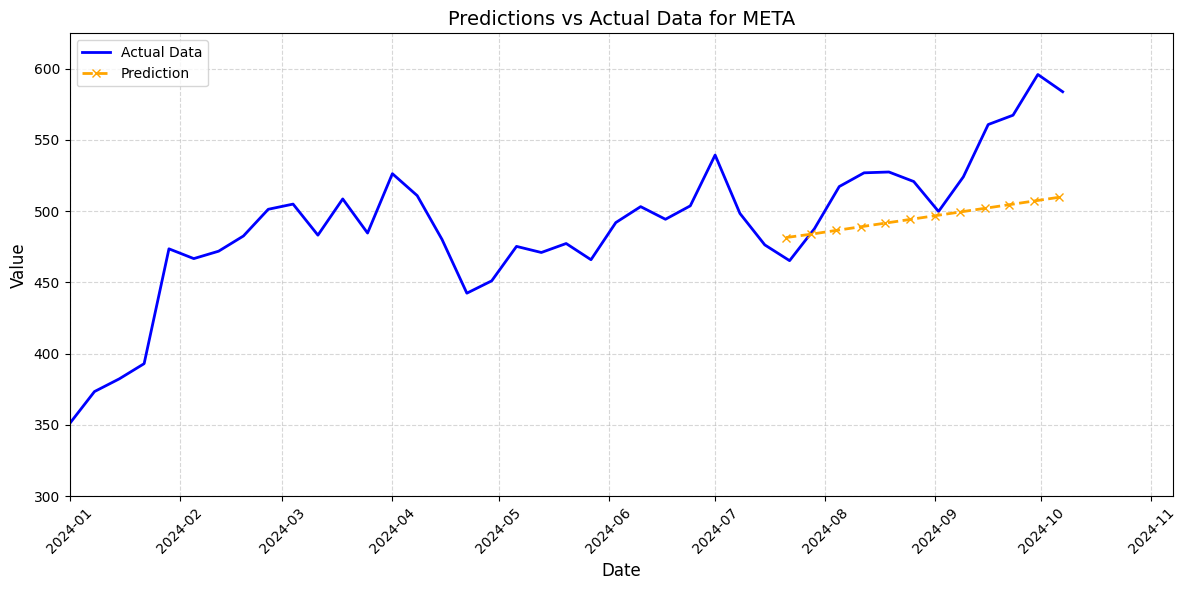


Graficando las predicciones para IBM...


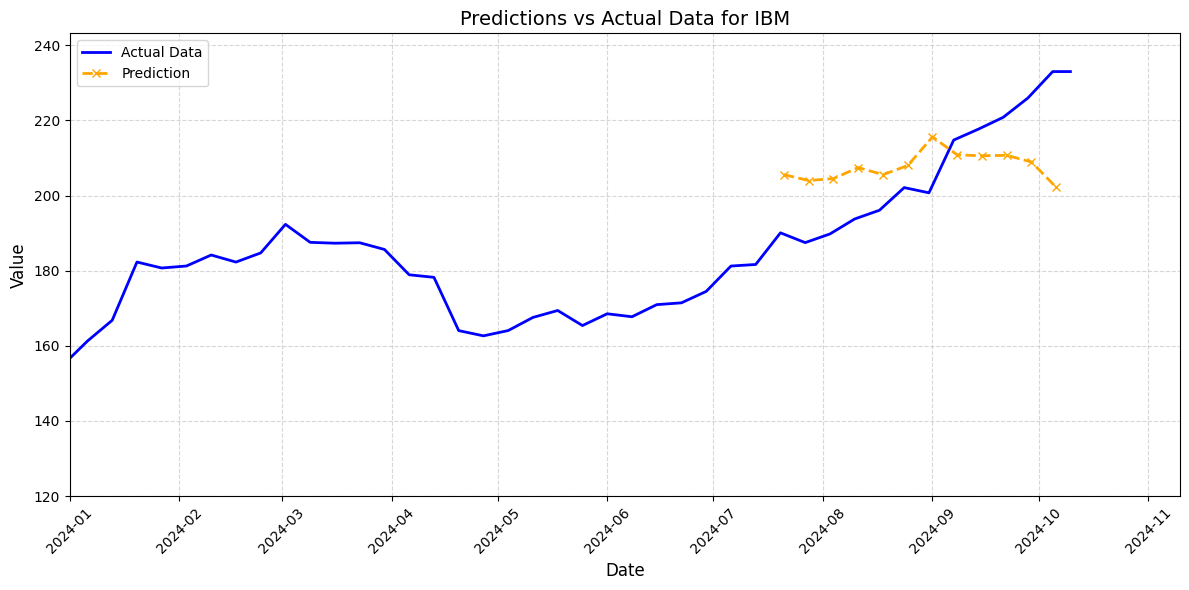


Graficando las predicciones para BTC-USD...


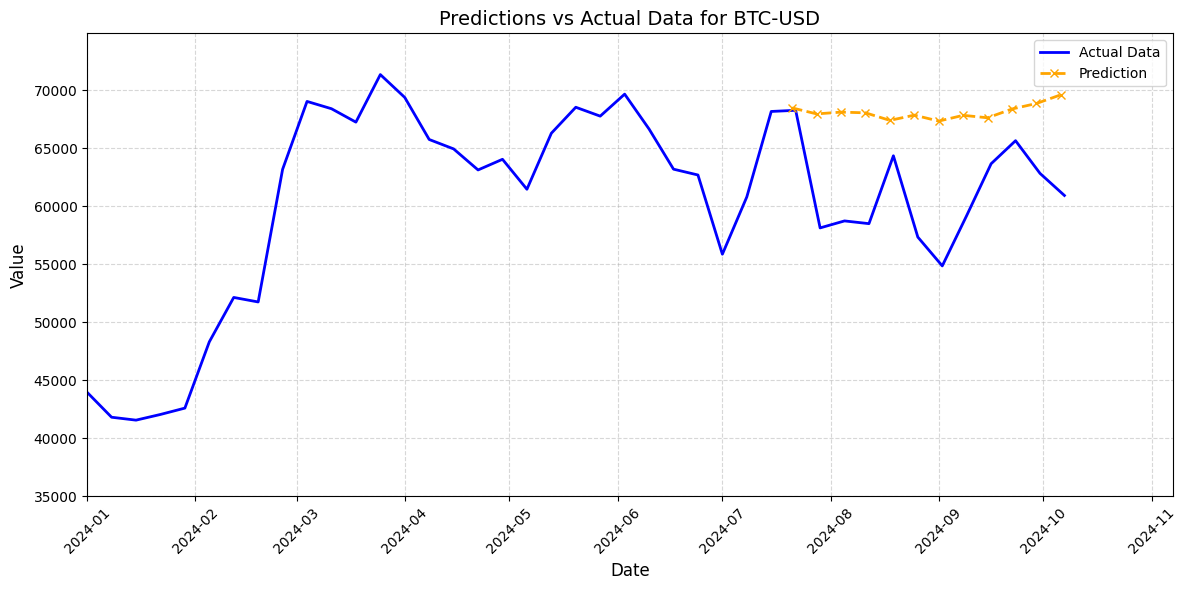

In [12]:
# Graficar resultados
for ticker in forecasts_dict:
    print(f"\nGraficando las predicciones para {ticker}...")
    plot_predictions(ticker, forecasts_dict[ticker])